<a href="https://www.kaggle.com/code/victorchawsukho/household-electricity-consumption?scriptVersionId=156898318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

!Kaggle Dataset(https://www.kaggle.com/datasets/thedevastator/240000-household-electricity-consumption-records/data)

Reactive Power: Reactive power, on the other hand, does not perform any useful work but is necessary for the operation of inductive devices such as motors and transformers. It is measured in kilovolt-amperes reactive (kVAR) or simply in kilowatts (kW) for convenience.
 "Global Reactive Power" is a measure of the reactive power consumption in the household, and it contributes to the overall understanding of the power characteristics of the electrical system.

| Column Name            | Description                                                                                     | Type     | Comments |
|------------------------|-------------------------------------------------------------------------------------------------|----------| -------- |
| Date                   | The date of the observation. (Date)                                                            | Date     | Only dates so we need to combine with time which creating a new variable |
| Time                   | The time of the observation. (Time)                                                            | Time     | Use |
| Global_active_power    | The total active power consumed by the household (kilowatts). (Numeric)                         | Numeric  | Target variable as we can predict the power consumption of the household |
| Global_reactive_power  | The total reactive power consumed by the household (kilowatts). (Numeric)                       | Numeric  | Not used because Reactive power uses for inductive devices such as motors and transformers |
| Voltage                | The voltage at which the electricity is delivered to the household (volts). (Numeric)          | Numeric  | Not use |
| Global_intensity       | The average current intensity delivered to the household (amps). (Numeric)                     | Numeric  | Not use |
| Sub_metering_1         | The active power consumed by the kitchen (kilowatts). (Numeric)                                 | Numeric  | Use |
| Sub_metering_2         | The active power consumed by the laundry room (kilowatts). (Numeric)                            | Numeric  | Use |
| Sub_metering_3         | The active power consumed by the electric water heater and air conditioner (kilowatts). (Numeric)| Numeric  | Use |


## Problem Statement
1. Time Series Analysis: Predict the household power consumption for the next day based on the previous 3 days of data. 
1. Prediction with Machine Learning: Predict the consumption based on other variables such as time, voltage, and sub-metering.


## Import Libraries and Data


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/240000-household-electricity-consumption-records/household_power_consumption.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
# df = pd.read_csv('household_power_consumption.csv')
df = pd.read_csv('/kaggle/input/240000-household-electricity-consumption-records/household_power_consumption.csv')
df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


## Data Cleaning and Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  260640 non-null  int64  
 1   Date                   260640 non-null  object 
 2   Time                   260640 non-null  object 
 3   Global_active_power    260640 non-null  object 
 4   Global_reactive_power  260640 non-null  object 
 5   Voltage                260640 non-null  object 
 6   Global_intensity       260640 non-null  object 
 7   Sub_metering_1         260640 non-null  object 
 8   Sub_metering_2         260640 non-null  object 
 9   Sub_metering_3         256869 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 19.9+ MB


#### Convert data types

In [5]:
# Date time type
df['Date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Date')
# df.index = df.set_index(df['Date_time']) #If you don't want to add to a new column or replace to the existing columns

# Numeric type
col_to_num = ['Global_active_power', 'Global_reactive_power','Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
df[col_to_num] = df[col_to_num].apply(lambda x : pd.to_numeric(x, errors='coerce') )

In [6]:
%%timeit

from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)

num_missing_val = df.isna().sum()
total_records = df.shape[0]
print(f"Before drop the missing values: {num_missing_val}\nIn Percentage: {num_missing_val/df.shape[0]*100}")
print("*"*100)

sel_cols = df.iloc[:, 3:9]

cols_imputed = knn_imputer.fit_transform(sel_cols)

df.iloc[:, 3:9] = cols_imputed

print(f"After drop the missing values: {df.isna().sum()}")

Before drop the missing values: index                       0
Date                        0
Time                        0
Global_active_power      3771
Global_reactive_power    3771
Voltage                  3771
Global_intensity         3771
Sub_metering_1           3771
Sub_metering_2           3771
Sub_metering_3           3771
Date_time                   0
dtype: int64
In Percentage: index                    0.000000
Date                     0.000000
Time                     0.000000
Global_active_power      1.446823
Global_reactive_power    1.446823
Voltage                  1.446823
Global_intensity         1.446823
Sub_metering_1           1.446823
Sub_metering_2           1.446823
Sub_metering_3           1.446823
Date_time                0.000000
dtype: float64
****************************************************************************************************
After drop the missing values: index                       0
Date                        0
Time                        0

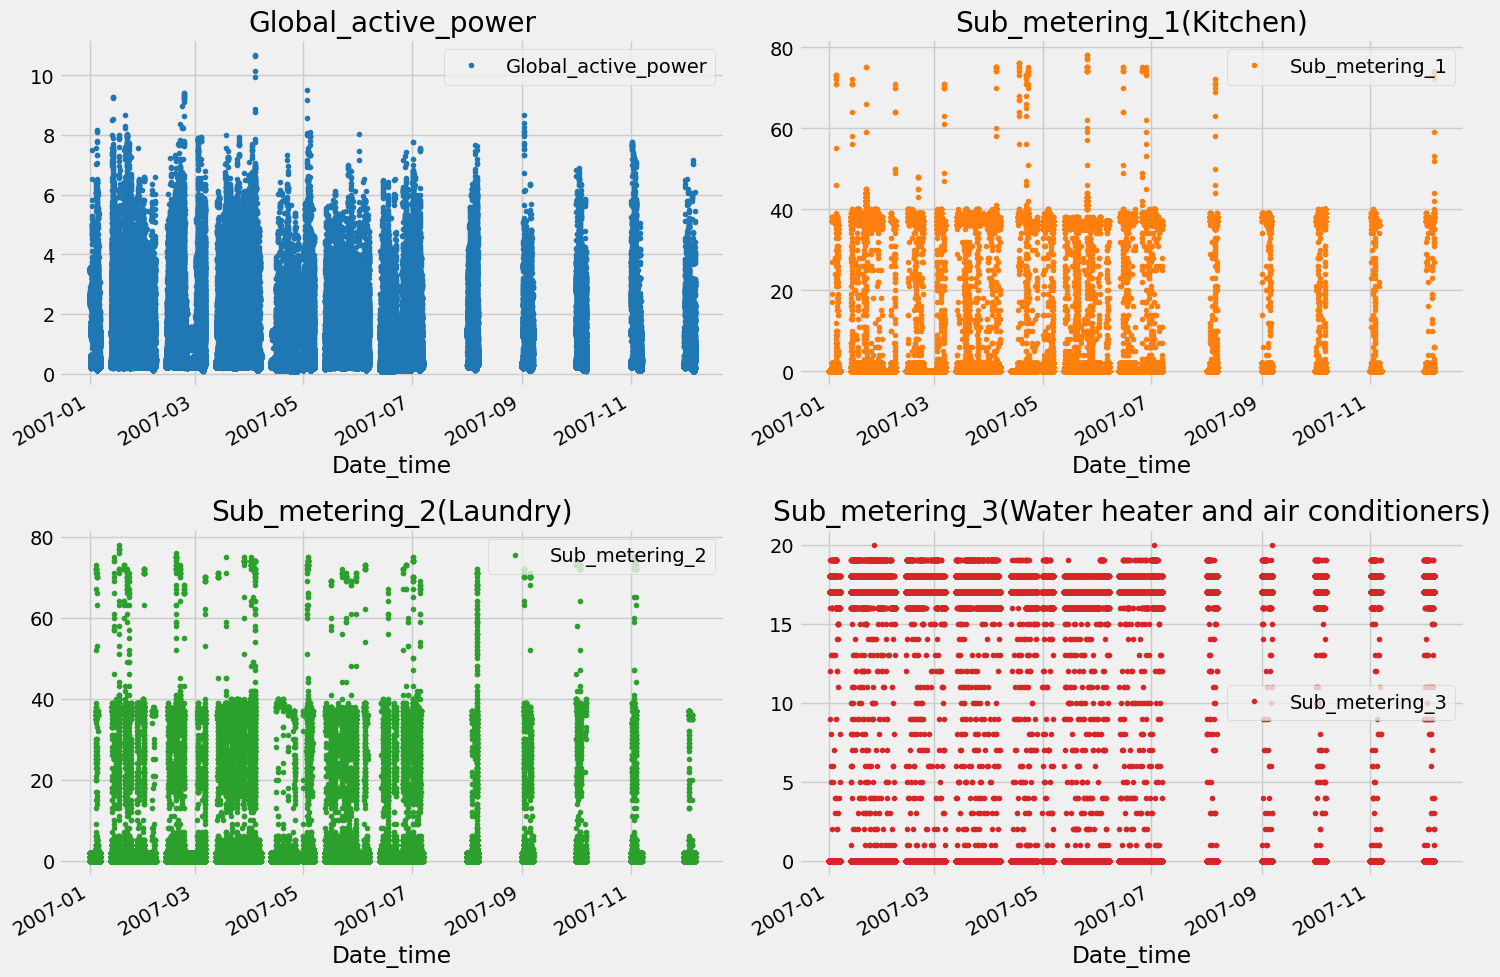

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

df.plot(x='Date_time', y='Global_active_power',style='.',color=color_pal[0], ax=axes[0,0], title='Global_active_power')
df.plot(x='Date_time', y='Sub_metering_1',style='.',color=color_pal[1], ax=axes[0,1], title='Sub_metering_1(Kitchen)')
df.plot(x='Date_time', y='Sub_metering_2',style='.',color=color_pal[2], ax=axes[1,0], title='Sub_metering_2(Laundry)')
df.plot(x='Date_time', y='Sub_metering_3',style='.',color=color_pal[3], ax=axes[1,1], title='Sub_metering_3(Water heater and air conditioners)')

plt.tight_layout()
plt.show()

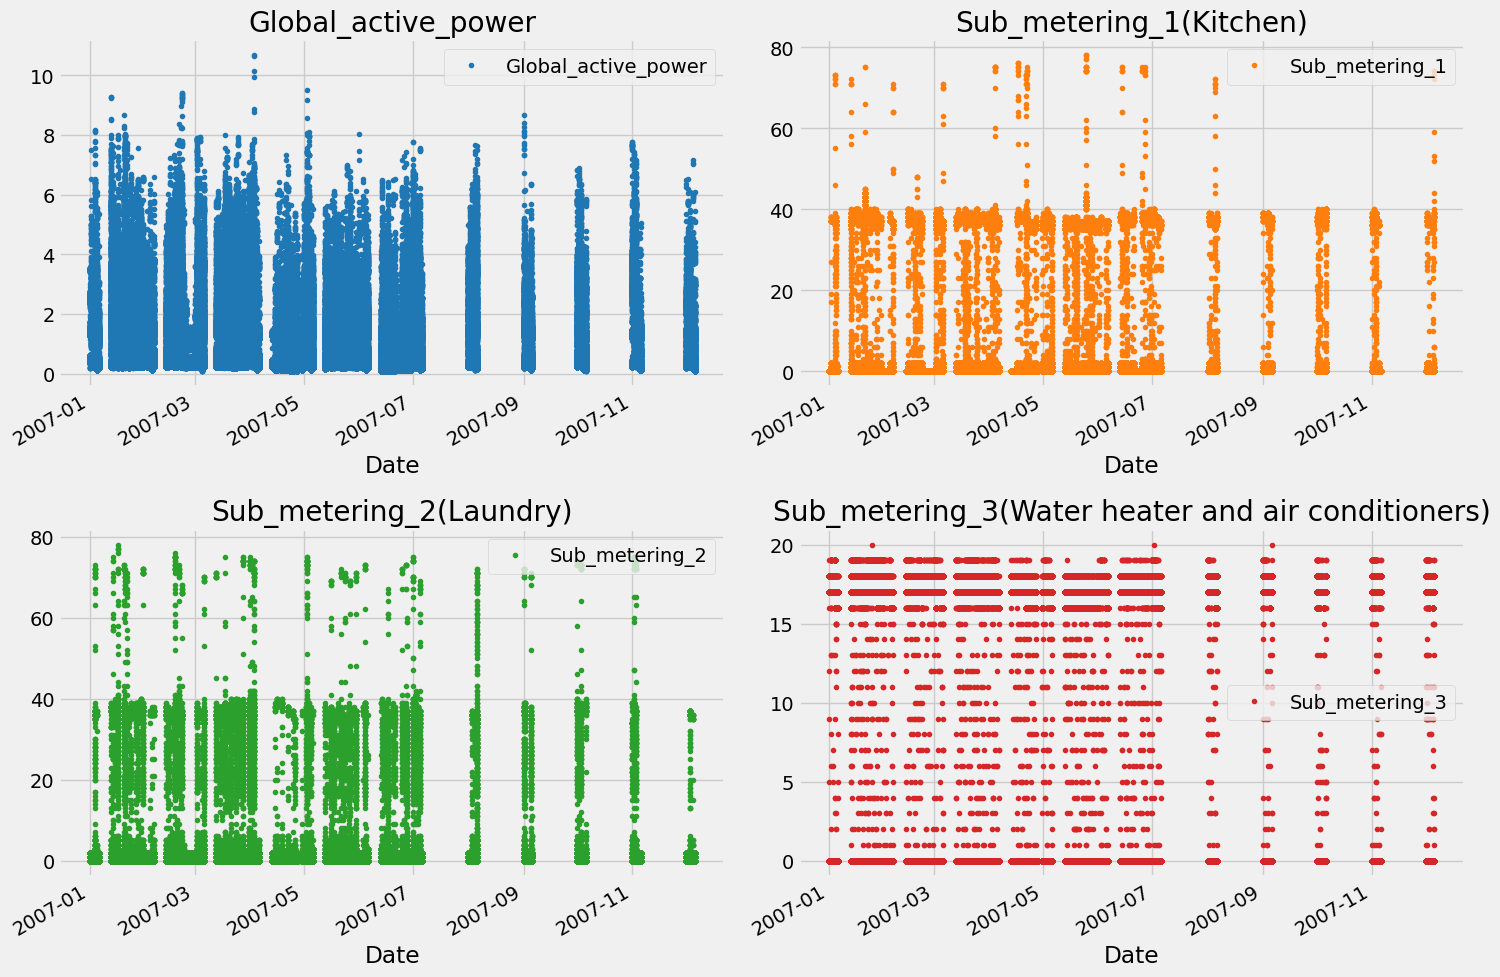

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

df.plot(x='Date', y='Global_active_power',style='.',color=color_pal[0], ax=axes[0,0], title='Global_active_power')
df.plot(x='Date', y='Sub_metering_1',style='.',color=color_pal[1], ax=axes[0,1], title='Sub_metering_1(Kitchen)')
df.plot(x='Date', y='Sub_metering_2',style='.',color=color_pal[2], ax=axes[1,0], title='Sub_metering_2(Laundry)')
df.plot(x='Date', y='Sub_metering_3',style='.',color=color_pal[3], ax=axes[1,1], title='Sub_metering_3(Water heater and air conditioners)')

plt.tight_layout()
plt.show()

In [9]:
df['year'] = df['Date_time'].apply(lambda x: x.year)
df['quarter'] = df['Date_time'].apply(lambda x: x.quarter)
df['month'] = df['Date_time'].apply(lambda x: x.month)
df['day'] = df['Date_time'].apply(lambda x: x.day)

In [10]:
df = df[['Date_time', 'Global_active_power',
       'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'year', 'quarter', 'month', 'day']]
df = df.sort_values('Date_time')
df = df.reset_index()

In [11]:
df.describe()

,index,Date_time,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,quarter,month,day
count,260640.000000,260640,260640.000000,260640.000000,260640.000000,256869.000000,260640.0,260640.000000,260640.000000,260640.000000
mean,130319.500000,2007-05-06 15:18:23.701657088,1.164937,1.332481,1.670610,5.831825,2007.0,1.900552,4.701657,14.408840
min,0.000000,2007-01-01 00:00:00,0.082000,0.000000,0.000000,0.000000,2007.0,1.000000,1.000000,1.000000
25%,65159.750000,2007-02-27 05:59:45,0.298000,0.000000,0.000000,0.000000,2007.0,1.000000,2.000000,4.000000
50%,130319.500000,2007-04-25 11:59:30,0.600000,0.000000,0.000000,0.000000,2007.0,2.000000,4.000000,16.000000
75%,195479.250000,2007-06-21 17:59:15,1.590000,0.000000,1.000000,17.000000,2007.0,2.000000,6.000000,23.000000
max,260639.000000,2007-12-06 23:59:00,10.670000,78.000000,78.000000,20.000000,2007.0,4.000000,12.000000,31.000000
std,75240.431418,NaN,1.173252,6.656289,6.583214,8.186709,0.0,0.940819,2.939440,9.828871


## Split data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   index                260640 non-null  int64         
 1   Date_time            260640 non-null  datetime64[ns]
 2   Global_active_power  260640 non-null  float64       
 3   Sub_metering_1       260640 non-null  float64       
 4   Sub_metering_2       260640 non-null  float64       
 5   Sub_metering_3       256869 non-null  float64       
 6   year                 260640 non-null  int64         
 7   quarter              260640 non-null  int64         
 8   month                260640 non-null  int64         
 9   day                  260640 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 19.9 MB


In [13]:
df.query('month < 9')[['Date_time','Global_active_power','month']]


,Date_time,Global_active_power,month
0,2007-01-01 00:00:00,2.580,1
1,2007-01-01 00:01:00,2.552,1
2,2007-01-01 00:02:00,2.550,1
3,2007-01-01 00:03:00,2.550,1
4,2007-01-01 00:04:00,2.554,1
...,...,...,...
226075,2007-08-06 23:55:00,1.136,8
226076,2007-08-06 23:56:00,1.100,8
226077,2007-08-06 23:57:00,1.190,8
226078,2007-08-06 23:58:00,1.184,8


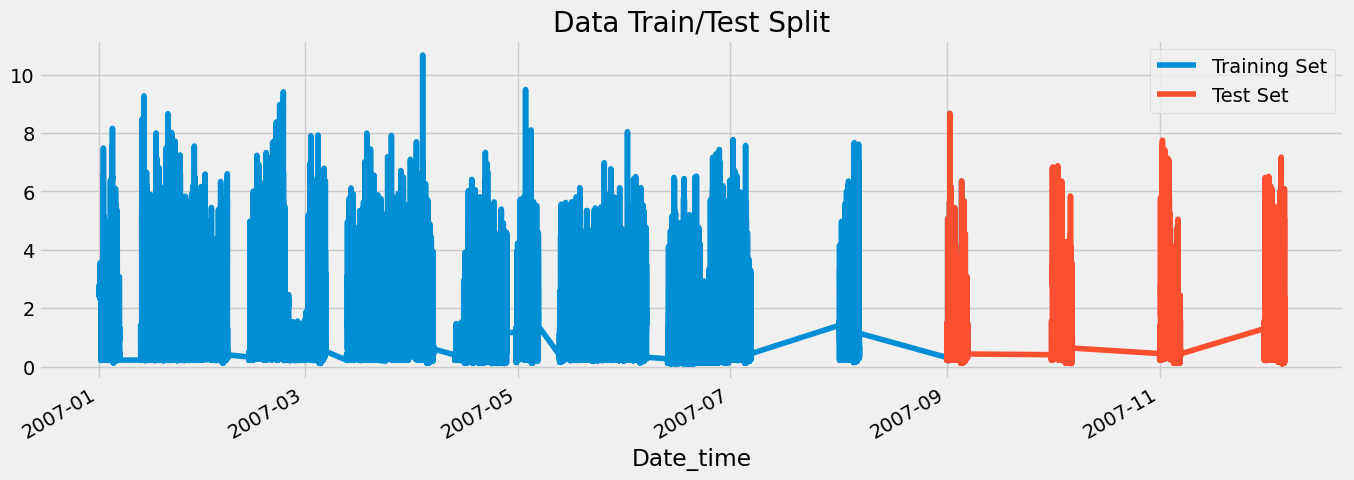

In [14]:
train = df.query('month <= 9')[['Date_time','Global_active_power','month']]
# test = df.loc[~(df['month'] < 9)]
test = df.query('month >= 9')[['Date_time','Global_active_power','month']]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='Date_time', y='Global_active_power', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(x='Date_time', y='Global_active_power', ax=ax, label='Test Set')
# ax.axvline(9, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()



In [15]:
# %pip install missingno
import missingno as msno

In [16]:
df_corr = df.corr().query('abs(Global_active_power) > 0.3')

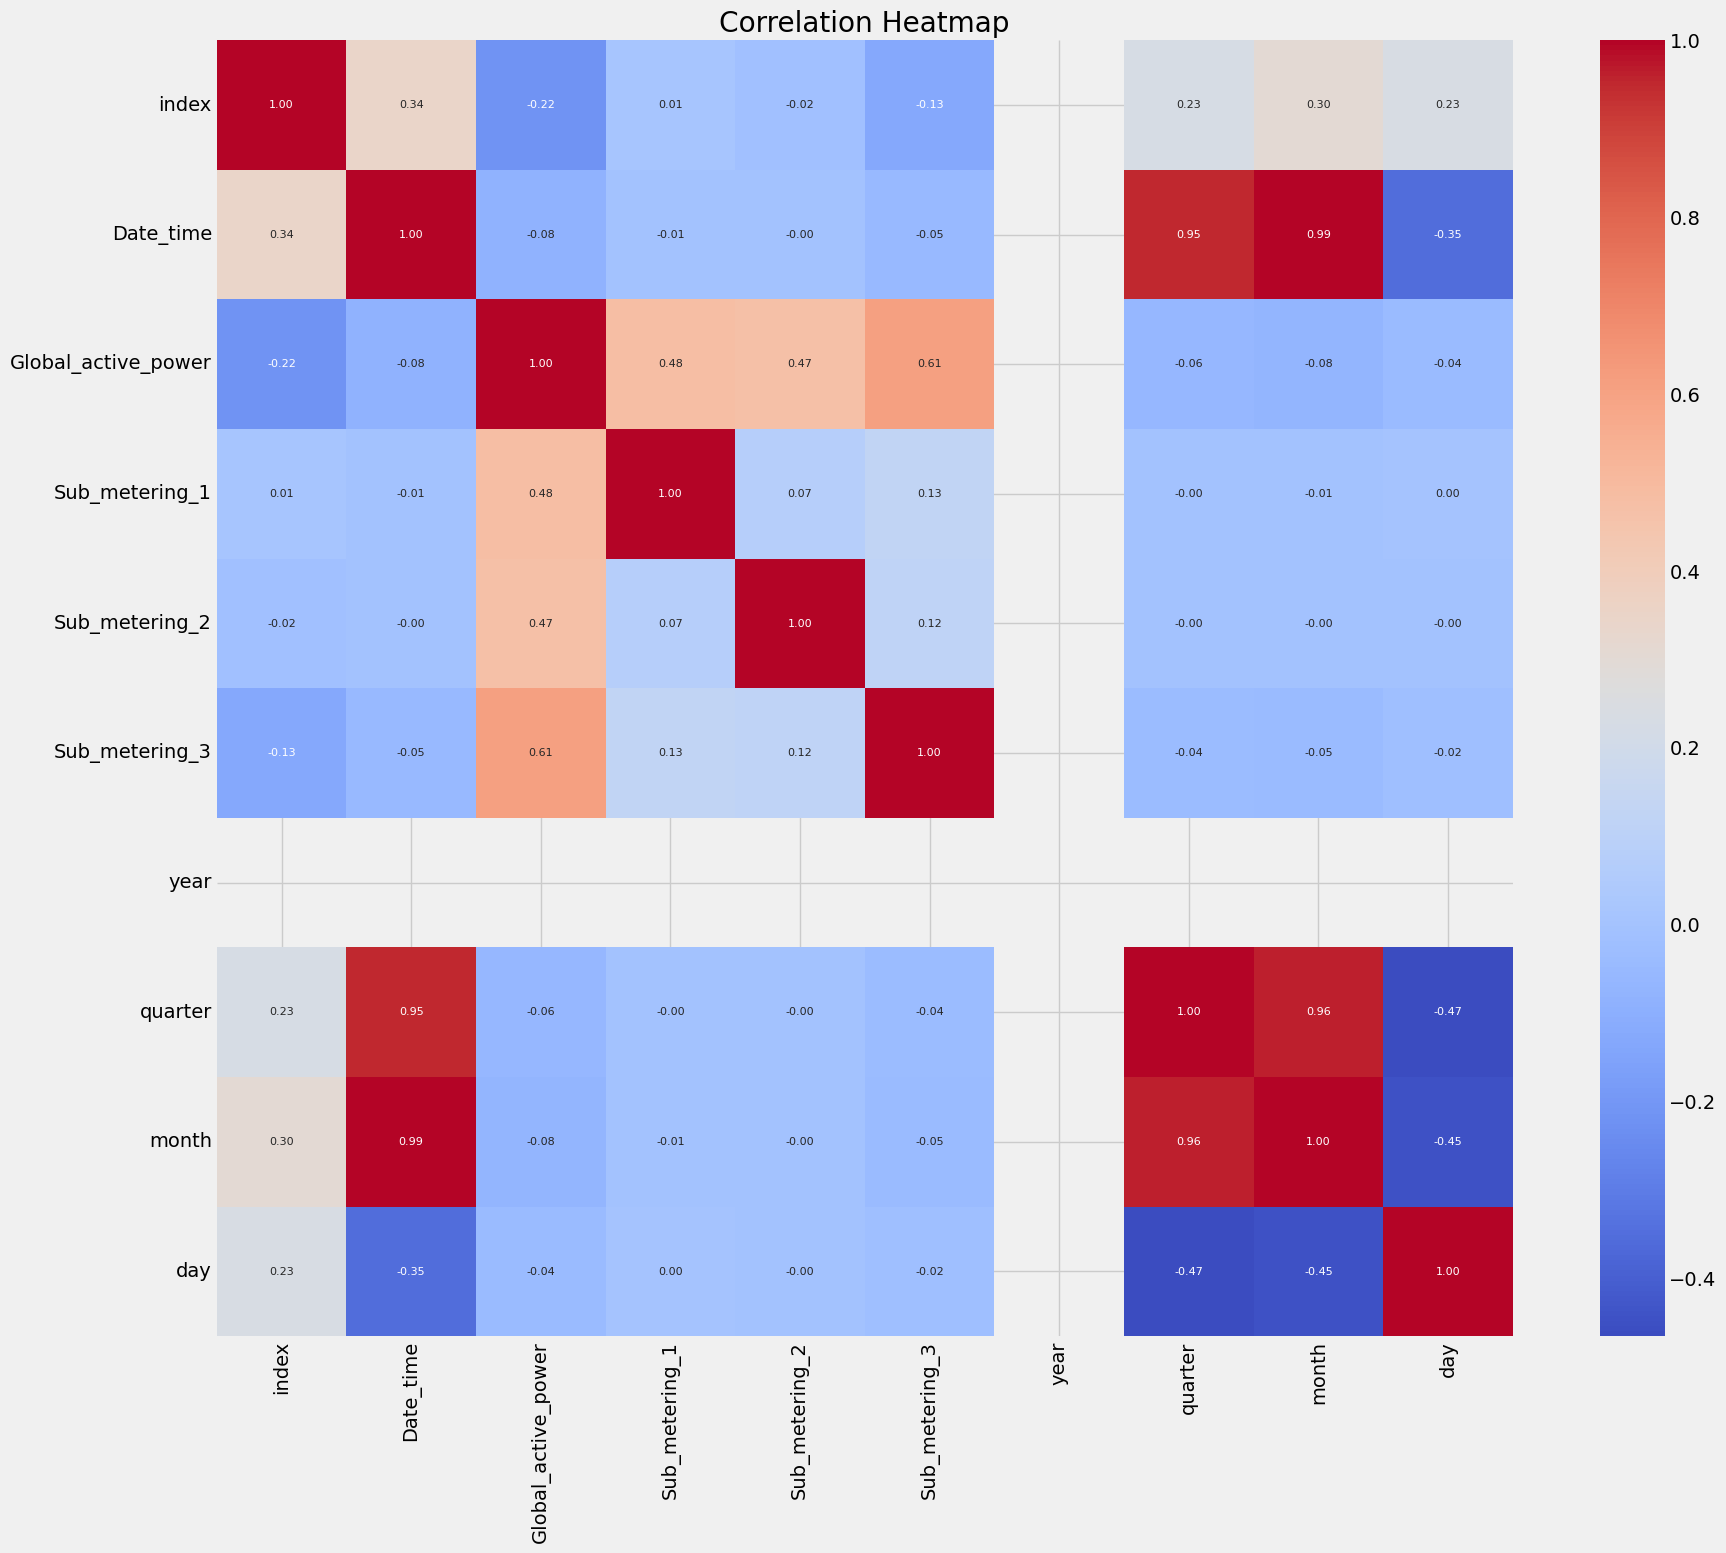

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 8}) #annot_kws sets font size
plt.title("Correlation Heatmap")
plt.show()